In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
import seaborn as sns
sns.set_style("white")

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# My packages
from source import parse_mxml as pm
from source import log_representation as lr
from source import plots as plts
from source import drift_detection as dd
from source import drift_localization as dl
from source import offline_streaming_clustering as off_sc
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import hdbscan

import random
random.seed(42)

import os
import glob

import gc
gc.enable()

In [2]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

def if_any(string, lista):
    for l in lista:
        if l in string:
            return True
    return False

In [3]:
logs = insensitive_glob("../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/*/*k.MXML")
logs

['../../../../../../..\\Datasets\\Business_Process_Drift_Logs\\Logs\\cb\\cb10k.mxml',
 '../../../../../../..\\Datasets\\Business_Process_Drift_Logs\\Logs\\cb\\cb2.5k.mxml',
 '../../../../../../..\\Datasets\\Business_Process_Drift_Logs\\Logs\\cb\\cb5k.mxml',
 '../../../../../../..\\Datasets\\Business_Process_Drift_Logs\\Logs\\cb\\cb7.5k.mxml',
 '../../../../../../..\\Datasets\\Business_Process_Drift_Logs\\Logs\\cd\\cd10k.mxml',
 '../../../../../../..\\Datasets\\Business_Process_Drift_Logs\\Logs\\cd\\cd2.5k.MXML',
 '../../../../../../..\\Datasets\\Business_Process_Drift_Logs\\Logs\\cd\\cd5k.MXML',
 '../../../../../../..\\Datasets\\Business_Process_Drift_Logs\\Logs\\cd\\cd7.5k.MXML',
 '../../../../../../..\\Datasets\\Business_Process_Drift_Logs\\Logs\\cf\\cf10k.mxml',
 '../../../../../../..\\Datasets\\Business_Process_Drift_Logs\\Logs\\cf\\cf2.5k.mxml',
 '../../../../../../..\\Datasets\\Business_Process_Drift_Logs\\Logs\\cf\\cf5k.mxml',
 '../../../../../../..\\Datasets\\Business_Process_D

In [4]:
logs = [x for x in logs if "2.5" not in x]

### Read and Prep log file

In [5]:
log_read = pm.all_prep(logs[1])
tokens = lr.get_traces_as_tokens(log_read)
y_true = list(range(int(len(tokens)/10), len(tokens), int(len(tokens)/10)))

### Vector space representations

In [210]:
activity_binary = lr.get_binary_representation(tokens)
transitions_binary = lr.get_binary_transitions_representation(tokens)
activity_frequency = lr.get_frequency_representation(tokens)
transitions_frequency = lr.get_frequency_transitions_representation(tokens)
activity_transitions_frequency = pd.concat([transitions_frequency, activity_frequency],axis=1)
activity_transitions_binary = pd.concat([transitions_binary, activity_binary],axis=1)

### Trace Clustering - Transitions Binary

In [7]:
# run_df = off_sc.run_offline_clustering_window(
# #     KMeans(n_clusters=3, random_state=42),
#     DBSCAN(eps=2, min_samples=3, metric='euclidean'),
#     75,
#     transitions_binary,
#     sliding_window=False,
#     sliding_step=1
# )

##### Features from the evolution of trace clustering

In [8]:
# run_df['std_diff_centroids'].plot(figsize=(16,4), c='red')
# plts.plot_drift_vertical_lines(len(activity_binary), label="True drift")
# plt.legend();

In [9]:
# run_df['avg_dist_intra_cluster'].plot(figsize=(16,4), c='red')
# plts.plot_drift_vertical_lines(len(activity_binary), label="True drift")
# plt.legend();

### Trace Clustering - Activity Binary

In [10]:
# clustering_window_size = 125

# run_df = off_sc.run_offline_clustering_window(
# #     KMeans(n_clusters=3, random_state=42),
#     DBSCAN(eps=2, min_samples=3, metric='euclidean'),
#     clustering_window_size,
#     activity_binary,
#     sliding_window=False,
#     sliding_step=1
# )

##### Features from the evolution of trace clustering

In [11]:
# run_df['avg_dist_between_centroids'].plot(figsize=(16,4))
# plts.plot_drift_vertical_lines(len(activity_binary), label="True drift")
# plt.legend();

In [12]:
# run_df['Silhouette'].plot(figsize=(16,4))
# plts.plot_drift_vertical_lines(len(activity_binary), label="True drift")
# plt.legend();

### Trace Clustering

In [211]:
clustering_window_size = 75
vector_representation= activity_transitions_binary
# model = DBSCAN(eps=2, min_samples=3, metric='euclidean')
model= hdbscan.HDBSCAN()

In [212]:
run_df = off_sc.run_offline_clustering_window(
    model,
    clustering_window_size,
    vector_representation,
    sliding_window=False,
    sliding_step=1
)

k


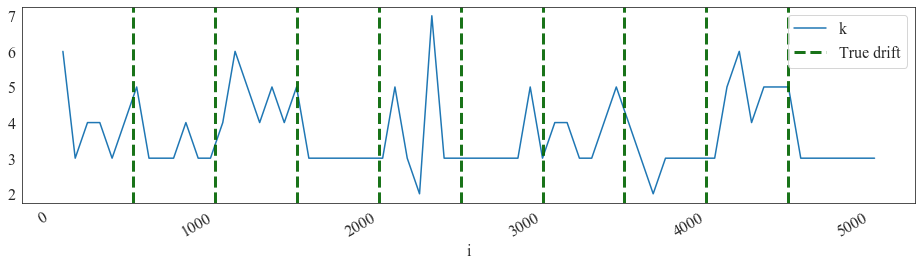

Silhouette


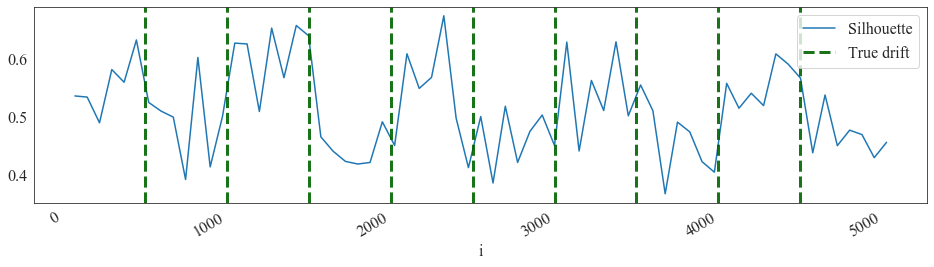

DBi


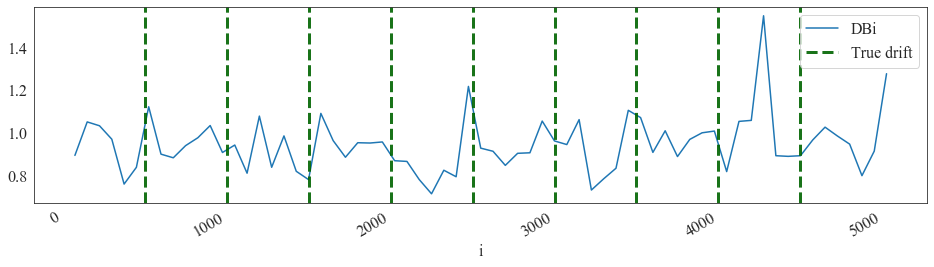

centroids
avg_dist_between_centroids


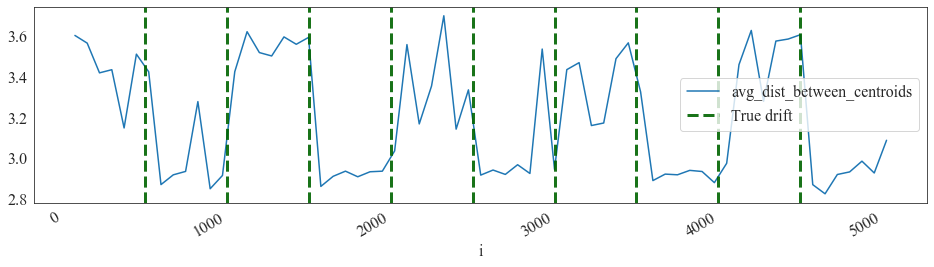

std_dist_between_centroids


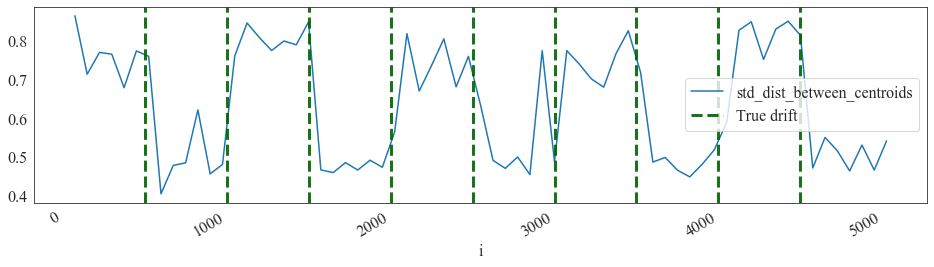

volume_list
radius_list
dist_intra_cluster_list
skewness_list
cluster_std_list
avg_radius


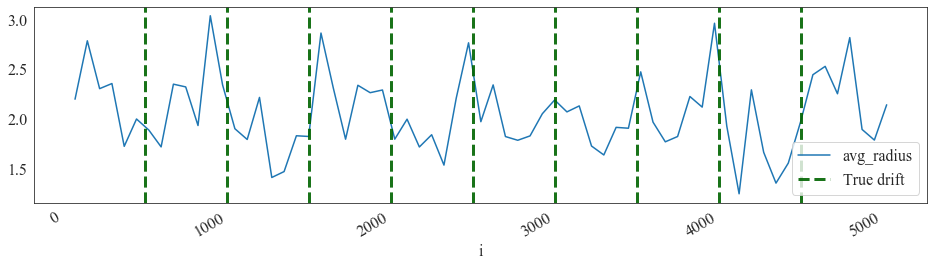

std_radius


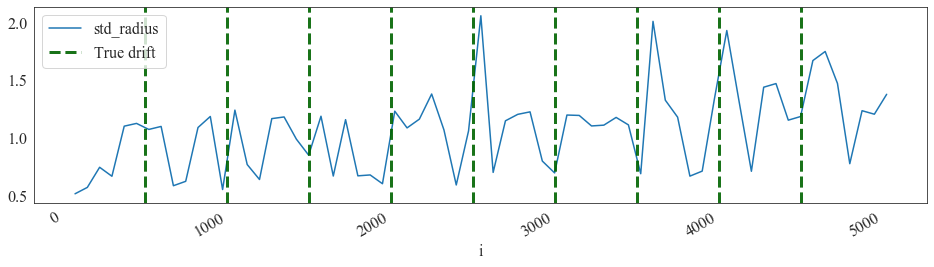

avg_dist_intra_cluster


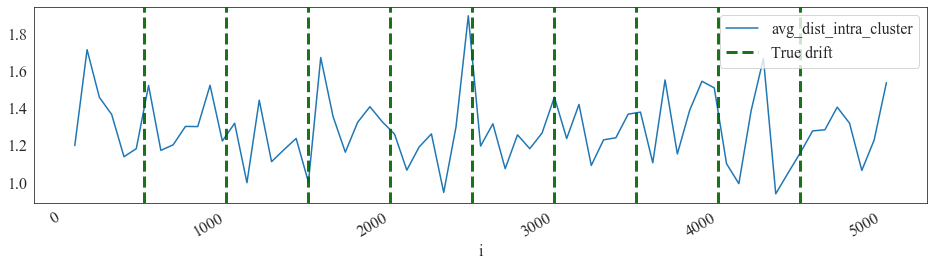

std_dist_intra_cluster


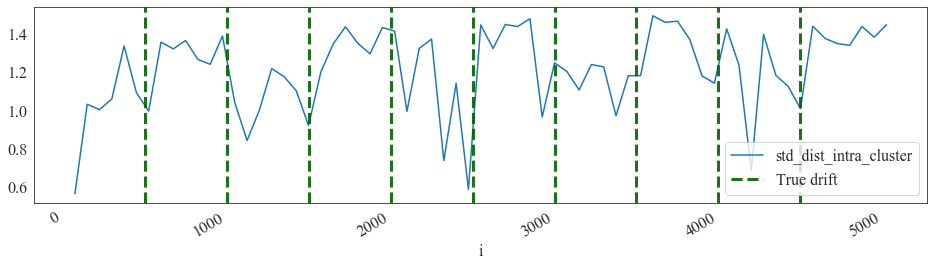

avg_skewness


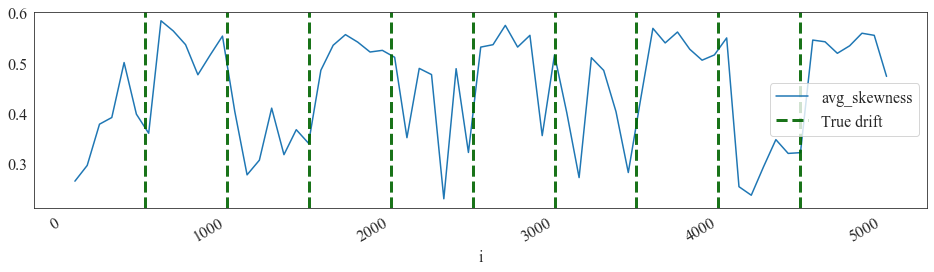

std_skewness


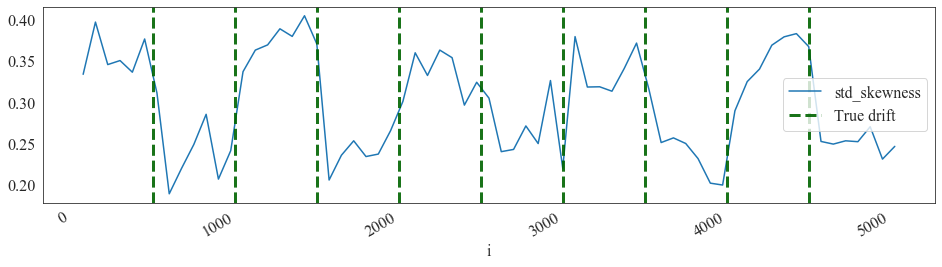

avg_cluster_std


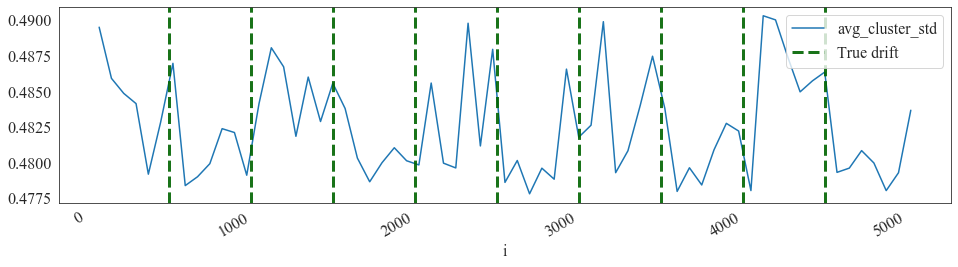

std_cluster_std


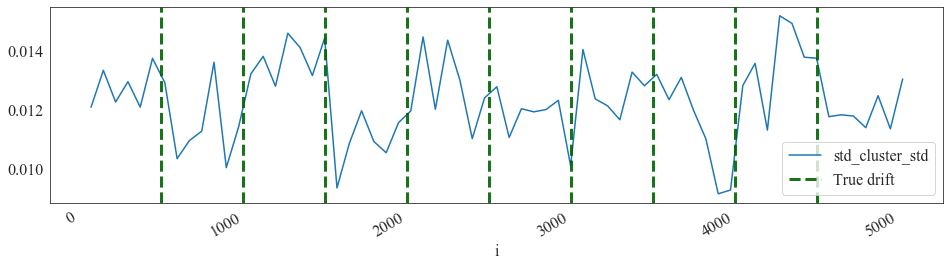

diff_k


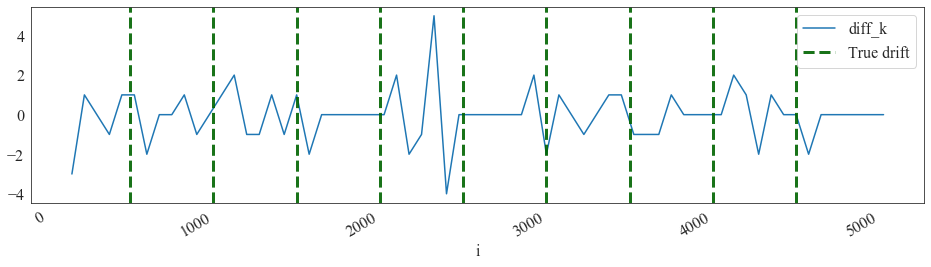

diff_Silhouette


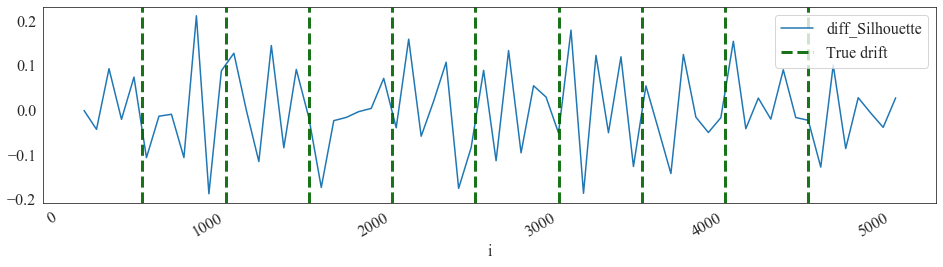

diff_DBi


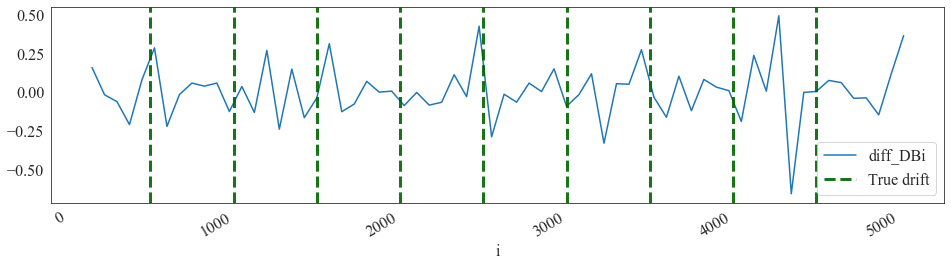

diff_centroids


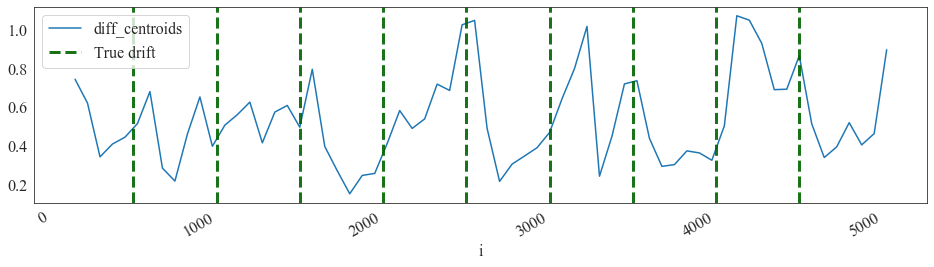

std_diff_centroids


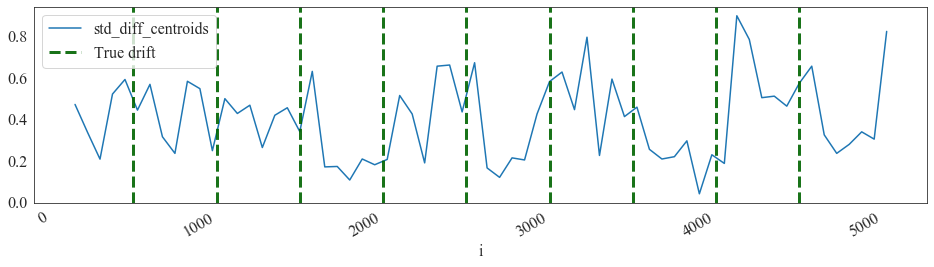

diff_avg_dist_between_centroids


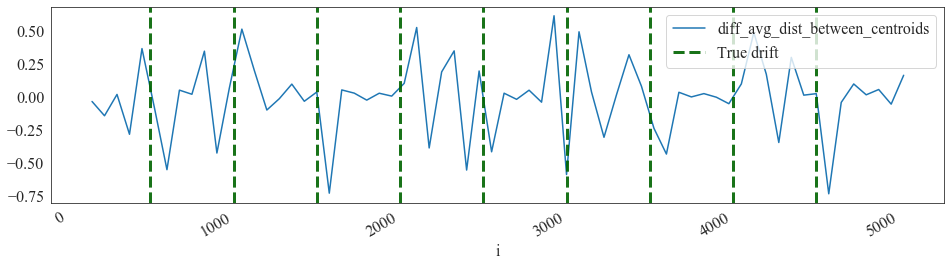

diff_std_dist_between_centroids


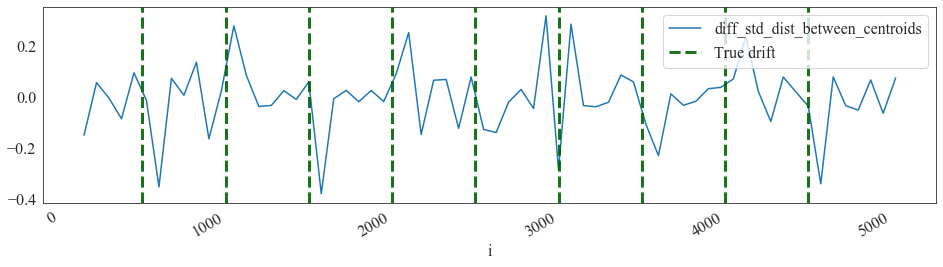

total_MSE


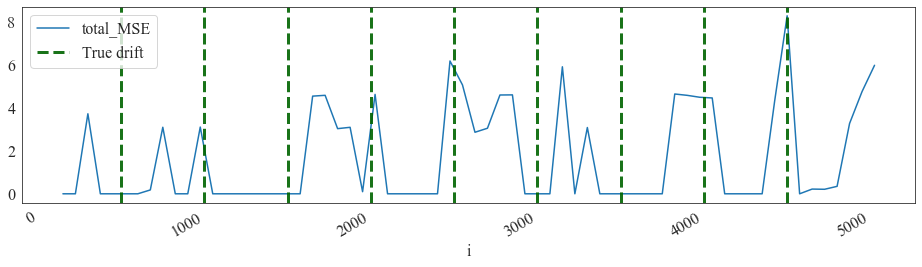

avg_MSE


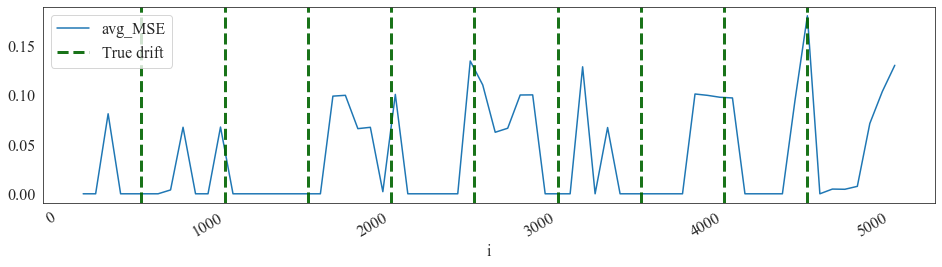

count_non_zero_MSE


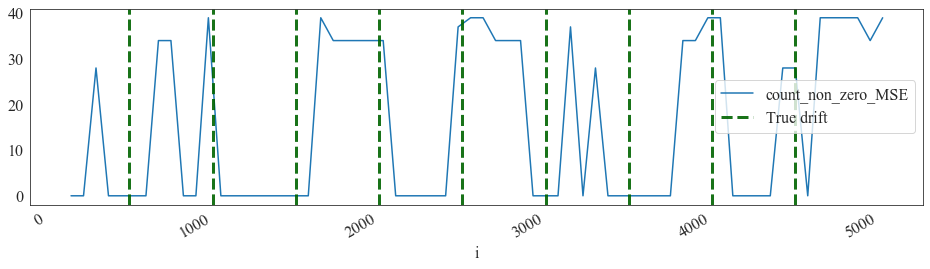

diff_volume
diff_radius


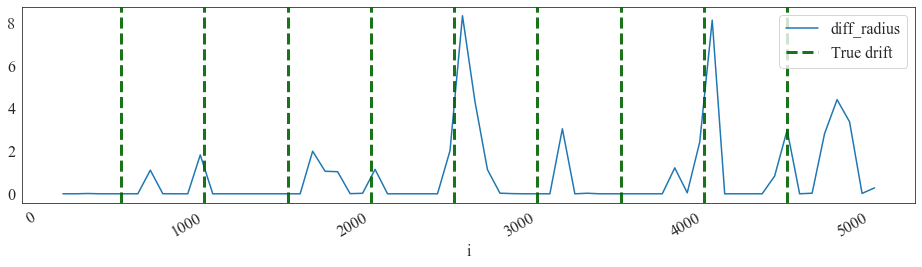

diff_dist_intra_cluster


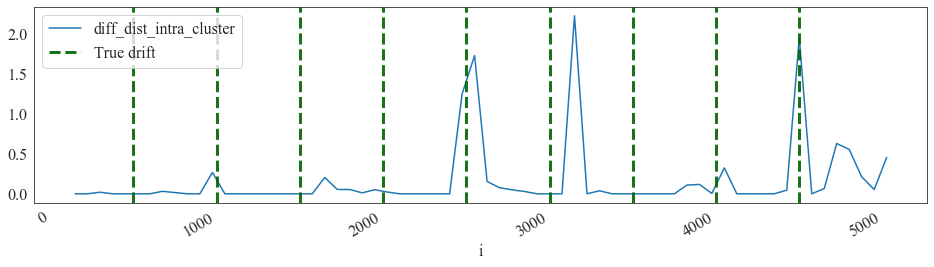

diff_skewness


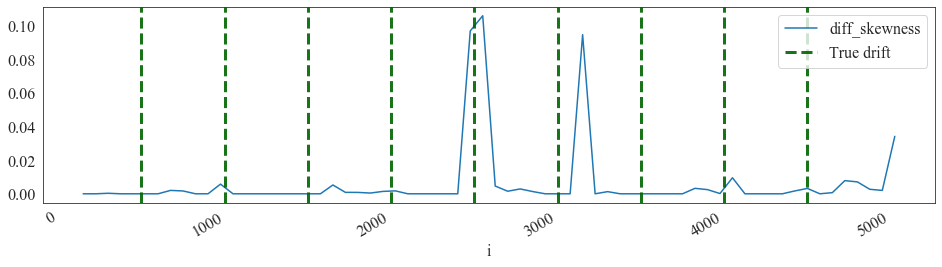

diff_cluster_std


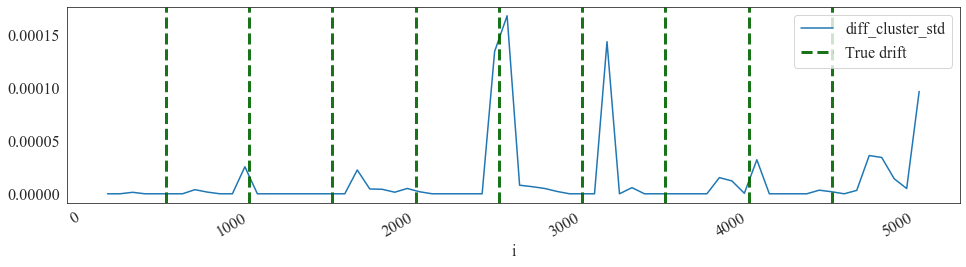

In [213]:
for i in run_df.columns:
    print(i)
    try:
        run_df[i].plot(figsize=(16,4),subplots=True)
        plts.plot_drift_vertical_lines(len(vector_representation), label="True drift")
        plt.legend()
        plt.show()
    except:
        pass

### Drift Detection

In [223]:
metric= 'avg_dist_between_centroids'

In [231]:
drifts, info = dd.detect_concept_drift(
    run_df,
    metric,
    rolling_window=6,
    std_tolerance=1.25,
    min_tol=0.01
)

dd.get_metrics(drifts, y_true, window_size=clustering_window_size)

{'Precision': 0.625,
 'Recall': 0.5555555555555556,
 'F1': 0.5882352941176471,
 'Delay': 100.0,
 'Correct_Predictions': [1, 1, 1, 0, 0, 0, 0, 1, 1],
 'Support': 5,
 'Drifts_Found': [600, 1125, 1650, 2325, 2925, 3450, 4050, 4575],
 'Resp': [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]}

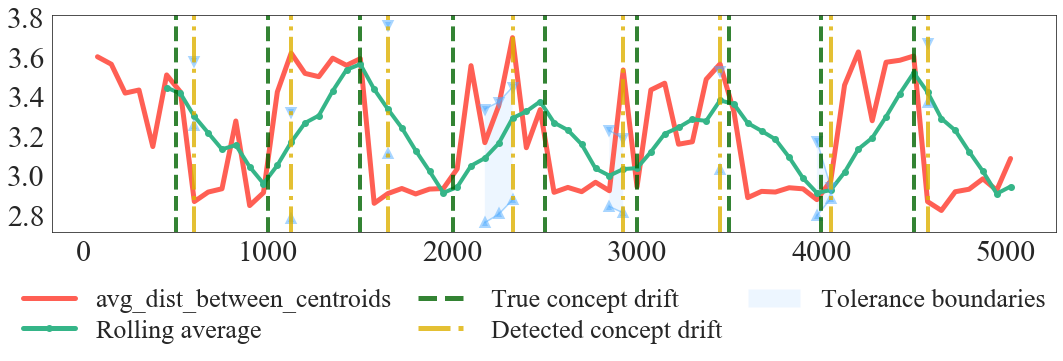

In [232]:
plts.plot_deteccao_drift(
    run_df,
    metric,
    drifts,
    y_true,
    info['means'],
    info['lowers'],
    info['uppers'],
    save_png=""
)

### Drift Localization

In [115]:
dl.localize_drift(
    run_df.centroids.loc[500], 
    run_df.centroids.loc[625], 
    activity_binary.columns
)

,0
Prepare_acceptance_pack,0.218272
Check_if_home_insurance_quote_is_requested,0.218272
Return_application_back_to_applicant,0.004165
Receive_updated_application,0.004165
Send_home_insurance_quote,0.001991
Send_acceptance_pack,0.001991
Loan__application_canceled,0.000596
Cancel_application,0.000596
Loan__application_approved,0.000596
Approve_application,0.000596


In [116]:
# Result of drift localization in the ground truth drifts

dl.localize_all_drifts(
    run_df,
    [x + clustering_window_size for x in y_true], 
    clustering_window_size,
    activity_binary.columns
)

,drift_at_625,drift_at_1125,drift_at_1625,drift_at_2125,drift_at_2625,drift_at_3125,drift_at_3625,drift_at_4125,drift_at_4625
Prepare_acceptance_pack,0.218272,0.134088,0.114800,0.075984,0.090939,9.183673e-02,0.147892,0.138035,0.097818
Check_if_home_insurance_quote_is_requested,0.218272,0.134088,0.114800,0.075984,0.090939,9.183673e-02,0.147892,0.138035,0.097818
Return_application_back_to_applicant,0.004165,0.006170,0.006983,0.002298,0.000758,3.427037e-03,0.005234,0.004569,0.002383
Receive_updated_application,0.004165,0.006170,0.006983,0.002298,0.000758,3.427037e-03,0.005234,0.004569,0.002383
Send_home_insurance_quote,0.001991,0.000846,0.004201,0.002298,0.002387,4.431490e-03,0.000860,0.005625,0.000052
Send_acceptance_pack,0.001991,0.000846,0.004201,0.002298,0.002387,4.431490e-03,0.000860,0.005625,0.000052
Loan__application_canceled,0.000596,0.004382,0.016806,0.007038,0.000122,5.991739e-07,0.008038,0.005625,0.001076
Cancel_application,0.000596,0.004382,0.016806,0.007038,0.000122,5.991739e-07,0.008038,0.005625,0.001076
Loan__application_approved,0.000596,0.004382,0.016806,0.007038,0.000122,5.991739e-07,0.008038,0.005625,0.001076
Approve_application,0.000596,0.004382,0.016806,0.007038,0.000122,5.991739e-07,0.008038,0.005625,0.001076


In [117]:
# Result of drift localization in all predicted drifts

dl.localize_all_drifts(
    run_df,
    drifts, 
    clustering_window_size,
    activity_binary.columns
)

,drift_at_625,drift_at_1125,drift_at_1625,drift_at_2125,drift_at_2625,drift_at_3125,drift_at_3625,drift_at_4125,drift_at_4625
Prepare_acceptance_pack,0.218272,0.134088,0.114800,0.075984,0.090939,9.183673e-02,0.147892,0.138035,0.097818
Check_if_home_insurance_quote_is_requested,0.218272,0.134088,0.114800,0.075984,0.090939,9.183673e-02,0.147892,0.138035,0.097818
Return_application_back_to_applicant,0.004165,0.006170,0.006983,0.002298,0.000758,3.427037e-03,0.005234,0.004569,0.002383
Receive_updated_application,0.004165,0.006170,0.006983,0.002298,0.000758,3.427037e-03,0.005234,0.004569,0.002383
Send_home_insurance_quote,0.001991,0.000846,0.004201,0.002298,0.002387,4.431490e-03,0.000860,0.005625,0.000052
Send_acceptance_pack,0.001991,0.000846,0.004201,0.002298,0.002387,4.431490e-03,0.000860,0.005625,0.000052
Loan__application_canceled,0.000596,0.004382,0.016806,0.007038,0.000122,5.991739e-07,0.008038,0.005625,0.001076
Cancel_application,0.000596,0.004382,0.016806,0.007038,0.000122,5.991739e-07,0.008038,0.005625,0.001076
Loan__application_approved,0.000596,0.004382,0.016806,0.007038,0.000122,5.991739e-07,0.008038,0.005625,0.001076
Approve_application,0.000596,0.004382,0.016806,0.007038,0.000122,5.991739e-07,0.008038,0.005625,0.001076
